In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.gmm import IV2SLS

## Data Organization

In [2]:
base_path = Path.cwd() / "derived"

sales_data = pd.read_excel(base_path / "Dailysales.xlsx")
precipitation_data = pd.read_excel(base_path / "Precip.xlsx")
consfoot_data = pd.read_excel(base_path / "ConsumerFootTraffic.xlsx")

sales_data['Date'] = pd.to_datetime(sales_data['Date'])
precipitation_data['Date'] = pd.to_datetime(precipitation_data['Date'])
consfoot_data['Date'] = pd.to_datetime(consfoot_data['Date'])

merged_data = sales_data.merge(precipitation_data, on='Date', how='left')
merged_data = merged_data.merge(consfoot_data, on='Date', how='left')

merged_data.to_csv(base_path / "merged_data.csv", index=False)

Adding weekend flag variable and outputting the merged data

In [3]:
# Creating 'IsWeekend' boolean column:
merged_data['IsWeekend'] = merged_data['DayOfWeek'].isin(['Saturday', 'Sunday']).astype(int)
merged_data['DayOfWeek'] = merged_data['DayOfWeek'].astype('category')

print("First few rows of merged_data:")
print(merged_data.head())
print("\nColumns in merged_data:")
print(merged_data.columns.tolist())

First few rows of merged_data:
        Date  TotalSales  DayOfWeek  Precipitation  Unique  IsWeekend
0 2023-01-01           3     Sunday              1       2          1
1 2023-01-02           8     Monday              1       7          0
2 2023-01-03          19    Tuesday              1      19          0
3 2023-01-04           4  Wednesday              1       4          0
4 2023-01-05           7   Thursday              1       6          0

Columns in merged_data:
['Date', 'TotalSales', 'DayOfWeek', 'Precipitation', 'Unique', 'IsWeekend']


# Performing Analysis

## Initial Ordinary Least Squares (OLS) Regression Analysis

In [4]:
# 1. OLS model to compare weekday sales with weekend sales
weekend_model = smf.ols('TotalSales ~ IsWeekend', data=merged_data).fit()
print("Weekend Model Summary:")
print(weekend_model.summary())
print("\n" + "="*50 + "\n")

# 2. OLS model with DayOfWeek
ols_model_dow = smf.ols('TotalSales ~ DayOfWeek', data=merged_data).fit()
print("Day of Week Model Summary:")
print(ols_model_dow.summary())
print("\n" + "="*50 + "\n")

Weekend Model Summary:
                            OLS Regression Results                            
Dep. Variable:             TotalSales   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     81.98
Date:                Sat, 29 Nov 2025   Prob (F-statistic):           8.57e-18
Time:                        01:23:55   Log-Likelihood:                -1408.9
No. Observations:                 365   AIC:                             2822.
Df Residuals:                     363   BIC:                             2830.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.9346      0.

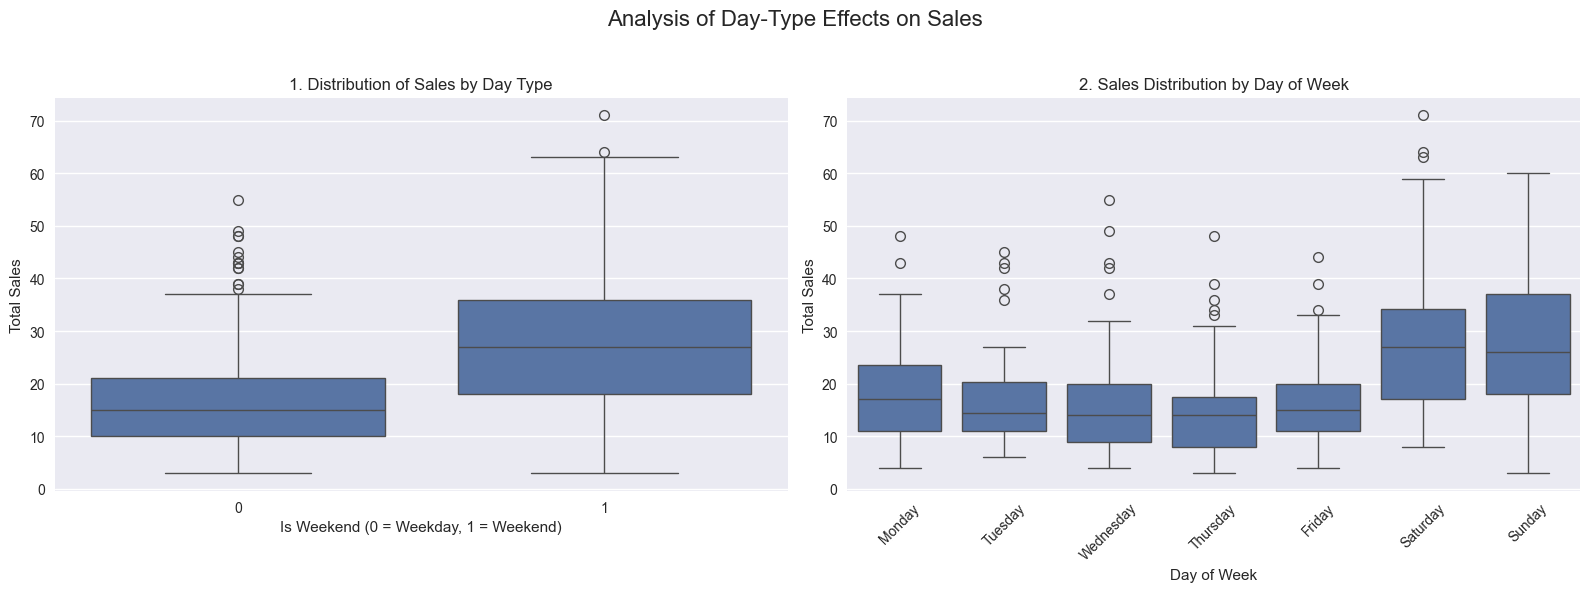

In [5]:
plt.style.use('seaborn-v0_8')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Analysis of Day-Type Effects on Sales', fontsize=16)

# Ploting Distribution by weekday vs. weekend
sns.boxplot(data=merged_data, x='IsWeekend', y='TotalSales', ax=axes[0])
axes[0].set_xlabel('Is Weekend (0 = Weekday, 1 = Weekend)')
axes[0].set_ylabel('Total Sales')
axes[0].set_title('1. Distribution of Sales by Day Type')

# Plotting Sales by Day of Week
sns.boxplot(data=merged_data, x='DayOfWeek', y='TotalSales', ax=axes[1], 
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Total Sales')
axes[1].set_title('2. Sales Distribution by Day of Week')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## OLS Model with Consumer Foot Traffic

In [6]:
# OLS model with IsWeekend and Unique
ols_model = smf.ols('TotalSales ~ IsWeekend + Unique', data=merged_data).fit()
print("OLS Model (IsWeekend + Unique) Summary:")
print(ols_model.summary())
print("\n" + "="*50 + "\n")

OLS Model (IsWeekend + Unique) Summary:
                            OLS Regression Results                            
Dep. Variable:             TotalSales   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     5268.
Date:                Sat, 29 Nov 2025   Prob (F-statistic):          2.29e-268
Time:                        01:23:55   Log-Likelihood:                -824.64
No. Observations:                 365   AIC:                             1655.
Df Residuals:                     362   BIC:                             1667.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

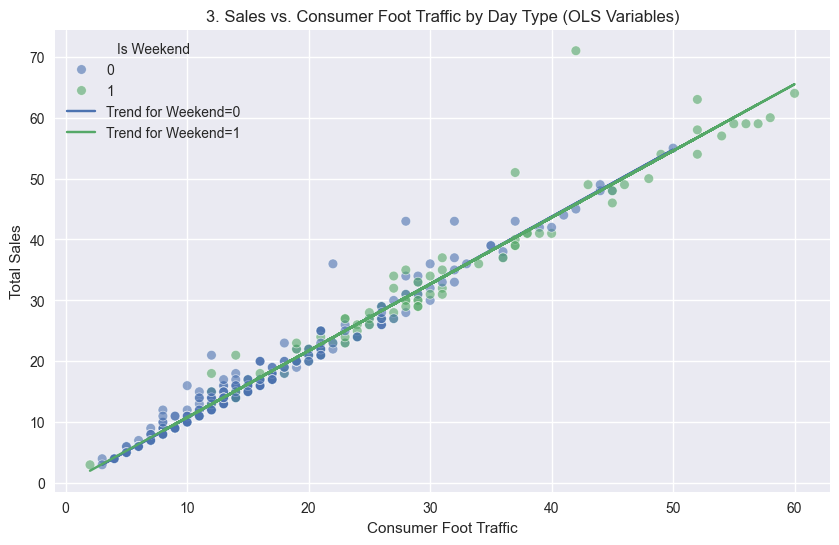

In [7]:
# Plotting Sales vs. Consumer Foot Traffic
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='Unique', y='TotalSales', hue='IsWeekend', alpha=0.6)

# And adding trend lines
for weekend in [0, 1]:
    subset = merged_data[merged_data['IsWeekend'] == weekend]
    z = np.polyfit(subset['Unique'], subset['TotalSales'], 1)
    p = np.poly1d(z)
    plt.plot(subset['Unique'], p(subset['Unique']), 
             label=f'Trend for Weekend={weekend}')
    
plt.xlabel('Consumer Foot Traffic')
plt.ylabel('Total Sales')
plt.title('3. Sales vs. Consumer Foot Traffic by Day Type (OLS Variables)')
plt.legend(title='Is Weekend')
plt.show()

## Two-Stage Least Squares (2SLS) and Precipitation Analysis

2SLS Model Summary:
                          IV2SLS Regression Results                           
Dep. Variable:             TotalSales   R-squared:                       0.693
Model:                         IV2SLS   Adj. R-squared:                  0.691
Method:                     Two Stage   F-statistic:                     108.7
                        Least Squares   Prob (F-statistic):           1.07e-37
Date:                Sat, 29 Nov 2025                                         
Time:                        01:23:55                                         
No. Observations:                 365                                         
Df Residuals:                     362                                         
Df Model:                           2                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9175     35.865

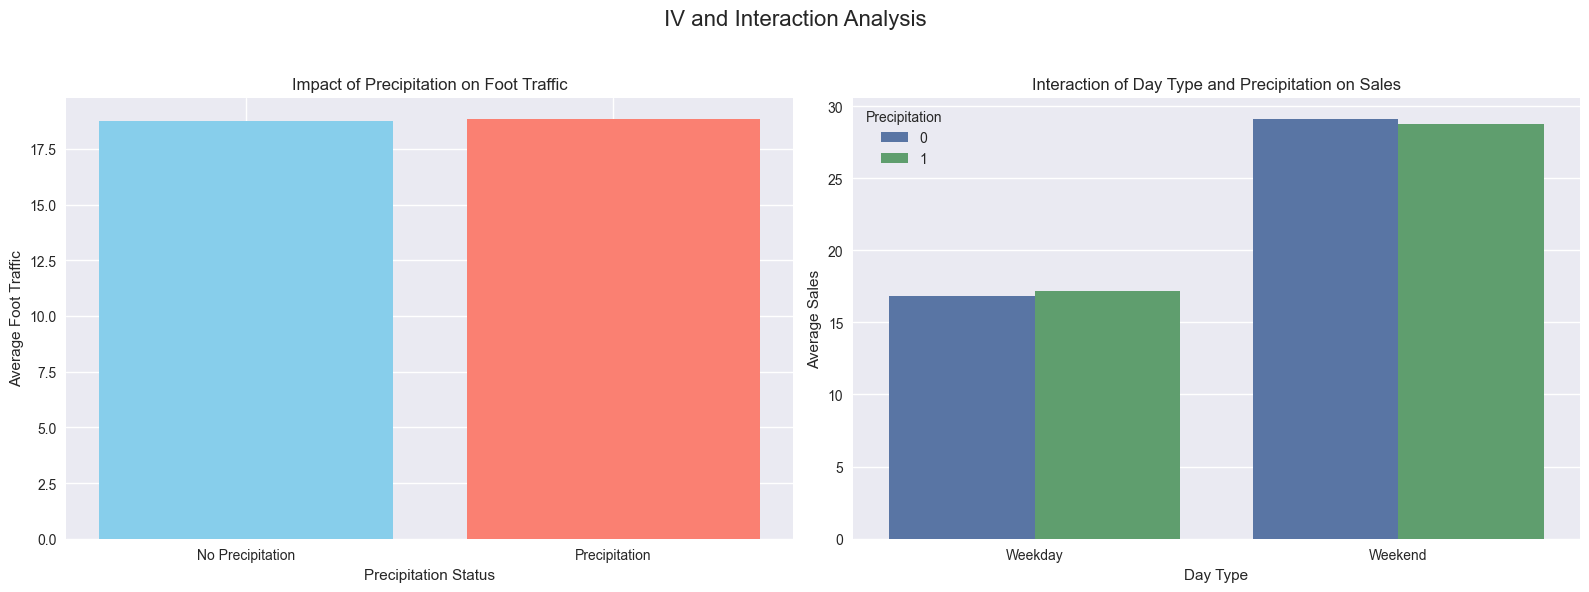

In [8]:
# Plotting the Effect of Precipitation on Consumer Foot Traffic
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('IV and Interaction Analysis', fontsize=16)

precip_means = merged_data.groupby('Precipitation')['Unique'].mean()
axes[0].bar(precip_means.index, precip_means.values, color=['skyblue', 'salmon'])
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['No Precipitation', 'Precipitation'])
axes[0].set_xlabel('Precipitation Status')
axes[0].set_ylabel('Average Foot Traffic')
axes[0].set_title('Impact of Precipitation on Foot Traffic')

# Setting up the 2SLS model
y = merged_data['TotalSales']
X = merged_data[['IsWeekend', 'Unique']]
X = sm.add_constant(X)  # Add constant term

# Instruments: Precipitation for Unique, IsWeekend for both
instruments = merged_data[['Precipitation', 'IsWeekend']]
instruments = sm.add_constant(instruments)

# Run 2SLS model
try:
    iv_model = IV2SLS(y, X, instruments).fit()
    print("2SLS Model Summary:")
    print(iv_model.summary())
except Exception as e:
    print(f"Error in IV2SLS: {e}")

print("\n" + "="*50 + "\n")

# Interaction Model Setup
merged_data['IsWeekend_Unique'] = merged_data['IsWeekend'] * merged_data['Unique']
merged_data['Precipitation_IsWeekend'] = merged_data['Precipitation'] * merged_data['IsWeekend']

# Model with interaction terms
X_int = merged_data[['IsWeekend', 'Unique', 'IsWeekend_Unique']]
X_int = sm.add_constant(X_int)

# Instruments for interaction model
instruments_int = merged_data[['IsWeekend', 'Precipitation', 'Precipitation_IsWeekend']]
instruments_int = sm.add_constant(instruments_int)

# Run interaction 2SLS model
try:
    iv_model2 = IV2SLS(y, X_int, instruments_int).fit()
    print("2SLS with Interaction Summary:")
    print(iv_model2.summary())
except Exception as e:
    print(f"Error in interaction IV2SLS: {e}")

print("\n" + "="*50 + "\n")

# Plotting Interaction between Precipitation, Day Type, and Sales
interaction_data = merged_data.groupby(['IsWeekend', 'Precipitation'])['TotalSales'].mean().reset_index()
sns.barplot(data=interaction_data, x='IsWeekend', y='TotalSales', hue='Precipitation', ax=axes[1])
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Weekday', 'Weekend'])
axes[1].set_xlabel('Day Type')
axes[1].set_ylabel('Average Sales')
axes[1].set_title('Interaction of Day Type and Precipitation on Sales')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Final Model Comparison and Time Series Overview

Model Comparison:
OLS R-squared (IsWeekend + Unique): 0.9667857741406245
2SLS R-squared (Simple IV): 0.6931448386723207

Time Series Overview:


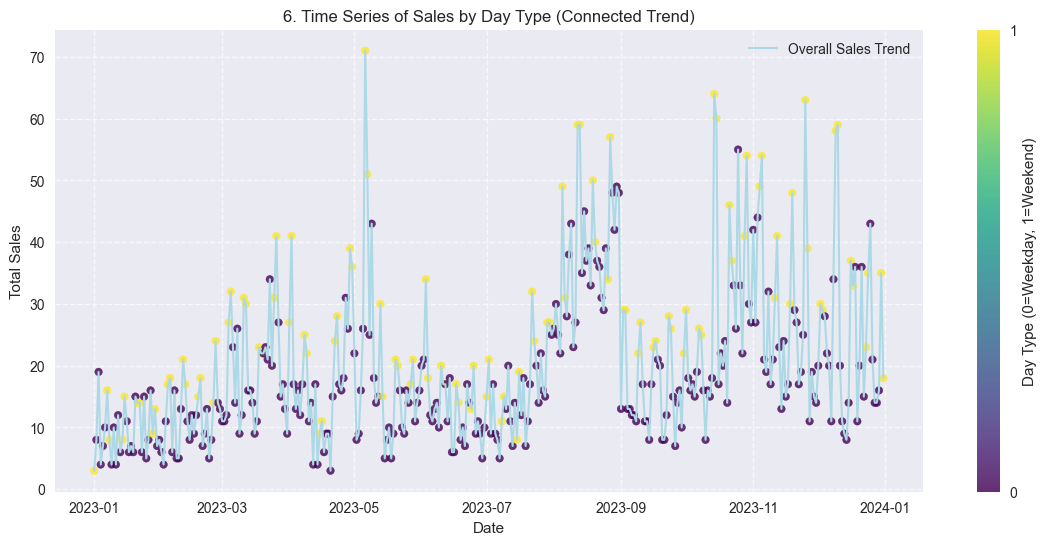

In [9]:
# Model comparison
print("Model Comparison:")
print("OLS R-squared (IsWeekend + Unique):", ols_model.rsquared)
try:
    print("2SLS R-squared (Simple IV):", iv_model.rsquared)
except:
    pass

print("\n" + "="*50)
print("Time Series Overview:")

# --- Revised Plot 6: Time series plot of sales ---
plt.figure(figsize=(14, 6))

# Ensure data is sorted by date before plotting the line
merged_data_sorted = merged_data.sort_values(by='Date')

# 1. Plot the continuous line for the overall trend in a pale light blue color
plt.plot(merged_data_sorted['Date'], merged_data_sorted['TotalSales'], 
         color='lightblue', linewidth=1.5, label='Overall Sales Trend') # Changed color to 'lightblue'

# 2. Overlay the scatter points, colored by IsWeekend, to highlight peaks
scatter = plt.scatter(merged_data['Date'], merged_data['TotalSales'], 
                      c=merged_data['IsWeekend'], alpha=0.8, cmap='viridis', s=30) # s=size of dots

plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('6. Time Series of Sales by Day Type (Connected Trend)')
plt.colorbar(scatter, ticks=[0, 1], label='Day Type (0=Weekday, 1=Weekend)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Model Comparison:
OLS R-squared (IsWeekend + Unique): 0.9667857741406245
2SLS R-squared (Simple IV): 0.6931448386723207

Time Series Overview:


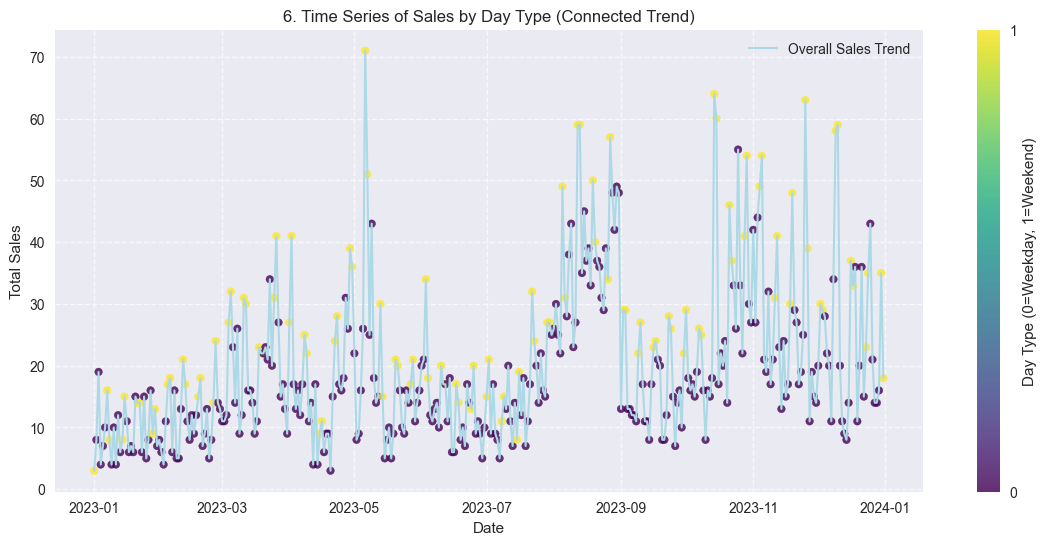

In [10]:
# Model comparison
print("Model Comparison:")
print("OLS R-squared (IsWeekend + Unique):", ols_model.rsquared)
try:
    print("2SLS R-squared (Simple IV):", iv_model.rsquared)
except:
    pass

print("\n" + "="*50)
print("Time Series Overview:")

# --- Revised Plot 6: Time series plot of sales ---
plt.figure(figsize=(14, 6))

# Ensure data is sorted by date before plotting the line
merged_data_sorted = merged_data.sort_values(by='Date')

# 1. Plot the continuous line for the overall trend in a pale light blue color
plt.plot(merged_data_sorted['Date'], merged_data_sorted['TotalSales'], 
         color='lightblue', linewidth=1.5, label='Overall Sales Trend') # Changed color to 'lightblue'

# 2. Overlay the scatter points, colored by IsWeekend, to highlight peaks
scatter = plt.scatter(merged_data['Date'], merged_data['TotalSales'], 
                      c=merged_data['IsWeekend'], alpha=0.8, cmap='viridis', s=30) # s=size of dots

plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('6. Time Series of Sales by Day Type (Connected Trend)')
plt.colorbar(scatter, ticks=[0, 1], label='Day Type (0=Weekday, 1=Weekend)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()